#  INSIGHTS ON AIRBNB BUSINESS IN SEATTLE & PRICE PREDICTION

### INTRODUCTION

Airbnb is an online marketplace that allows people easily rent places for shortstays, vacations, business travels and so on; and as the word "marketplace" implies, as much as there are parties renting places, there are also the people who rent out these places. This marketplace can be easily accessed through the mobile application or website. 

One of the challenges that renters (hosts) as well as customers of Airbnb face is determining the best price to charge and pay for a listing.

This project aims to interpret the Airbnb Seattle dataset of 2016 retrieved from Kaggle and answer some business questions listed below.



1.) When is the busiest time of the year and what is the average price at that time ? 

2.) Which neighborhoods are the most expensive ?

3.) Which listing features influence price? (Build a predictive pricing model)

4.) Does cancellatation policies have an effect on booking ?

 



The data can be found here : https://www.kaggle.com/datasets/airbnb/seattle





In [1]:
#Data analysis
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import folium 
from folium import plugins

#model
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

### READING THE DATA

In [2]:
calendar = pd.read_csv (r'/Users/omoyeniogundipe/Desktop/Project1/SeattleData/calendar.csv')

listings = pd.read_csv (r'/Users/omoyeniogundipe/Desktop/Project1/SeattleData/listings.csv')

reviews = pd.read_csv (r'/Users/omoyeniogundipe/Desktop/Project1/SeattleData/reviews.csv')

### DATA UNDERSTANDING

### Calendar

In [3]:
calendar.head(2)
calendar.tail(2)
calendar.count()
calendar.dtypes
calendar.describe(include = 'all')

listing_id        date available    price
count   1.393570e+06     1393570   1393570   934542
unique           NaN         365         2      669
top              NaN  2016-09-11         t  $150.00
freq             NaN        3818    934542    36646
mean    5.550111e+06         NaN       NaN      NaN
std     2.962274e+06         NaN       NaN      NaN
min     3.335000e+03         NaN       NaN      NaN
25%     3.258213e+06         NaN       NaN      NaN
50%     6.118244e+06         NaN       NaN      NaN
75%     8.035212e+06         NaN       NaN      NaN
max     1.034016e+07         NaN       NaN      NaN

In [4]:
calendar.sample(5)

listing_id        date available    price
1105436     7455706  2016-08-07         t   $70.00
708361      4163851  2016-09-21         t  $129.00
1136761     2934389  2016-06-03         t   $93.00
525013      8036985  2016-05-26         t  $168.00
917578       533443  2016-12-02         f      NaN

In [5]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


#### How many listings in the calendar data and for how long ?



In [6]:
print("There are {} listings in the Calendar data for {} days, beginning {} and ending {}".
      format(len(calendar.listing_id.unique()),len(calendar.date.unique()),
             calendar.date.min(),calendar.date.max()))



There are 3818 listings in the Calendar data for 365 days, beginning 2016-01-04 and ending 2017-01-02


In [7]:
#We can see that there are missing price data in the dataset. How many missing price values are there? 
print('There are no price data for {} rows'.
                       format(np.sum(calendar.price.isnull())))


There are no price data for 459028 rows


In [8]:
#grouping the prices by availability to understand further why half the price variable has NA values

calendar.groupby('available').price.count()

available
f         0
t    934542
Name: price, dtype: int64

#### 
After grouping the prices by availabilility, between True and False values we can see that when availability is false,the price is not available. and when true, the prices are shown.

### Listings

In [9]:
listings.head(2)
listings.tail(2)
listings.count()
listings.dtypes
listings.describe(include = 'all')

id                           listing_url     scrape_id  \
count   3.818000e+03                                  3818  3.818000e+03   
unique           NaN                                  3818           NaN   
top              NaN  https://www.airbnb.com/rooms/4950847           NaN   
freq             NaN                                     1           NaN   
mean    5.550111e+06                                   NaN  2.016010e+13   
std     2.962660e+06                                   NaN  0.000000e+00   
min     3.335000e+03                                   NaN  2.016010e+13   
25%     3.258256e+06                                   NaN  2.016010e+13   
50%     6.118244e+06                                   NaN  2.016010e+13   
75%     8.035127e+06                                   NaN  2.016010e+13   
max     1.034016e+07                                   NaN  2.016010e+13   

       last_scraped                    name  \
count          3818                    3818   
unique            1                    3792   
top      2016-01-04  Capitol Hill Apartment   
freq           3818                       3   
mean            NaN                     NaN   
std             NaN                     NaN   
min             NaN                     NaN   
25%             NaN                     NaN   
50%             NaN                     NaN   
75%             NaN                     NaN   
max             NaN                     NaN   

                                                  summary  \
count                                                3641   
unique                                               3478   
top     This is a modern fully-furnished studio apartm...   
freq                                                   15   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                                    space  \
count                                                3249   
unique                                               3119   
top     *Note: This fall, there will be major renovati...   
freq                                                   14   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                              description experiences_offered  \
count                                                3818                3818   
unique                                               3742                   1   
top     Our space is a mix of a hostel and a home. We ...                none   
freq                                                   10                3818   
mean                                                  NaN                 NaN   
std                                                   NaN                 NaN   
min                                                   NaN                 NaN   
25%                                                   NaN                 NaN   
50%                                                   NaN                 NaN   
75%                                                   NaN                 NaN   
max                                                   NaN                 NaN   

                                    neighborhood_overview  ...  \
count                              

In [10]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [11]:
listings.shape

(3818, 92)

### Reviews

In [12]:
reviews.head(2)
reviews.tail(2)
reviews.count()
reviews.dtypes
reviews.describe(include = 'all')

listing_id            id        date   reviewer_id reviewer_name  \
count   8.484900e+04  8.484900e+04       84849  8.484900e+04         84849   
unique           NaN           NaN        1930           NaN         14380   
top              NaN           NaN  2015-09-21           NaN         David   
freq             NaN           NaN         580           NaN           870   
mean    3.005067e+06  3.058765e+07         NaN  1.701301e+07           NaN   
std     2.472877e+06  1.636613e+07         NaN  1.353704e+07           NaN   
min     4.291000e+03  3.721000e+03         NaN  1.500000e+01           NaN   
25%     7.946330e+05  1.725127e+07         NaN  5.053141e+06           NaN   
50%     2.488228e+06  3.228809e+07         NaN  1.413476e+07           NaN   
75%     4.694479e+06  4.457648e+07         NaN  2.762402e+07           NaN   
max     1.024814e+07  5.873651e+07         NaN  5.281274e+07           NaN   

                                                 comments  
count                                               84831  
unique                                              84136  
top     The host canceled this reservation the day bef...  
freq                                                   57  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

In [13]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [14]:
len(reviews['listing_id'].unique())

3191

In [15]:
#Do all the listings in the dataset have reviews?

missing_reviews = listings.shape[0] - len(reviews['listing_id'].unique())
print('No, {} listings do not have reviews'.format(missing_reviews))

No, 627 listings do not have reviews


### DATA CLEANING & PREP

### Calendar

In [16]:
#removing $ signs
calendar['price'] = calendar['price'].replace({'\$': '', ',': ''}, regex=True)

In [17]:
#changing dataType
calendar['price'] = pd.to_numeric(calendar['price'])
calendar['date']= pd.to_datetime(calendar['date'])

In [18]:
#Changing the categorical variable 'available' to dummy variables 

calendar['available'] = calendar.available.map(lambda x : 1 if x == 't' else 0)

In [19]:
calendar['available'].sample(20)

1032128    1
1214280    1
564815     1
1113196    0
300736     1
470372     0
1132314    1
251546     0
706710     1
12891      1
1174009    1
528161     0
1218814    1
871928     0
927159     1
1151197    1
139923     0
1362444    1
824944     1
470470     0
Name: available, dtype: int64

### Listings

In [20]:
#Removing $ signs in the price column 
listings.price = listings.price.str.replace('$', '').str.replace(',', '')

In [21]:
#changing data type 
listings['price'] = listings['price'].astype(float)

### ANSWERING QUESTIONS



### 1. When is the busiest time of the year and what is the average price at that time ? 

To answer this question, we have to determine occupancy rate and also we will look at monthly average prices and look at how they change by the month 

In [22]:
new_calendar = calendar.groupby('date')['available', 'price'].mean().reset_index()
new_calendar.rename(columns= {'price':'average_price', 'available': 'availability'}, inplace = 'true')
new_calendar.head(2)

date  availability  average_price
0 2016-01-04      0.454426     122.085879
1 2016-01-05      0.488999     120.681307

In [23]:
#determining the averavge occupancy % 

new_calendar['occupancy'] = (1- new_calendar['availability'])* 100
new_calendar.head(5)

date  availability  average_price  occupancy
0 2016-01-04      0.454426     122.085879  54.557360
1 2016-01-05      0.488999     120.681307  51.100052
2 2016-01-06      0.478261     120.928258  52.173913
3 2016-01-07      0.465165     120.958896  53.483499
4 2016-01-08      0.466737     127.640853  53.326349

In [24]:
new_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           365 non-null    datetime64[ns]
 1   availability   365 non-null    float64       
 2   average_price  365 non-null    float64       
 3   occupancy      365 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.5 KB


In [25]:
#creating columns for day  and month 


new_calendar['day'] = new_calendar.date.dt.day_name().str[:3]
new_calendar['month'] = new_calendar.date.dt.month_name().str[:3]

In [26]:
new_calendar.sample(5)

date  availability  average_price  occupancy  day month
183 2016-07-05      0.625196     150.522832  37.480356  Tue   Jul
318 2016-11-17      0.714248     134.526953  28.575170  Thu   Nov
27  2016-01-31      0.620220     119.159628  37.977999  Sun   Jan
204 2016-07-26      0.629387     150.124844  37.061289  Tue   Jul
80  2016-03-24      0.704819     128.383872  29.518072  Thu   Mar

In [27]:
def plot_answers(x, y):
    
    df_index = list(new_calendar[x].unique())
    grouped_df = new_calendar.groupby(
        x)[y].mean().reindex(df_index)

    plt.plot(grouped_df)
    plt.ylabel(y.replace('_', ' ').title())
    plt.title(" {} by {}".format(y.replace('_', ' ').title(),
                                 x.title()), fontsize=16, fontweight='bold')
    # points on the x axis where the label should appear
    ticks = list(range(len(df_index)))
    labels = df_index
    plt.xticks(ticks, labels)
    plt.show()

In [28]:
plt.style.use('seaborn-poster') 
plt.style.use('seaborn-whitegrid')

### When is the busiest time of the year? 

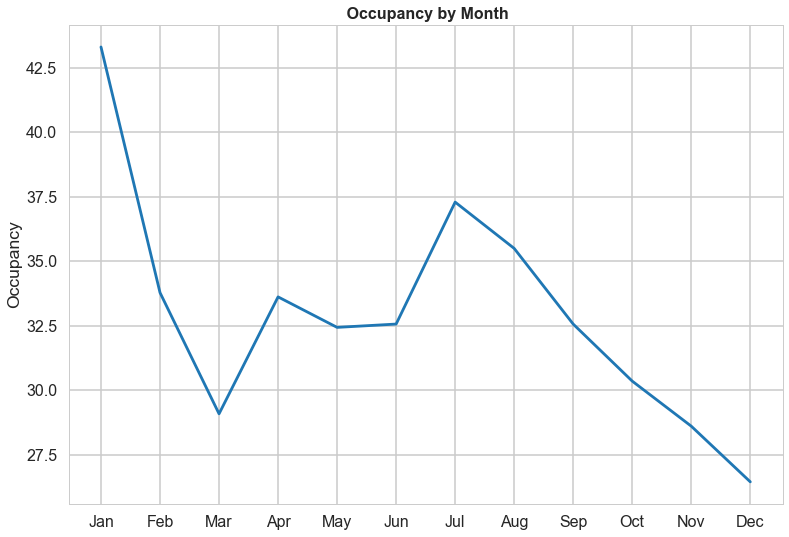

In [29]:

plot_answers('month', 'occupancy')

### 
From the analysis of our data, the Busiest time for Airbnb listings 
in Seattle is around January. Then we see a decline in occupancy 
from the peak period till March and then the occupancy rate begins 
to rise again. 




### What are the average prices at the busiest time ? 

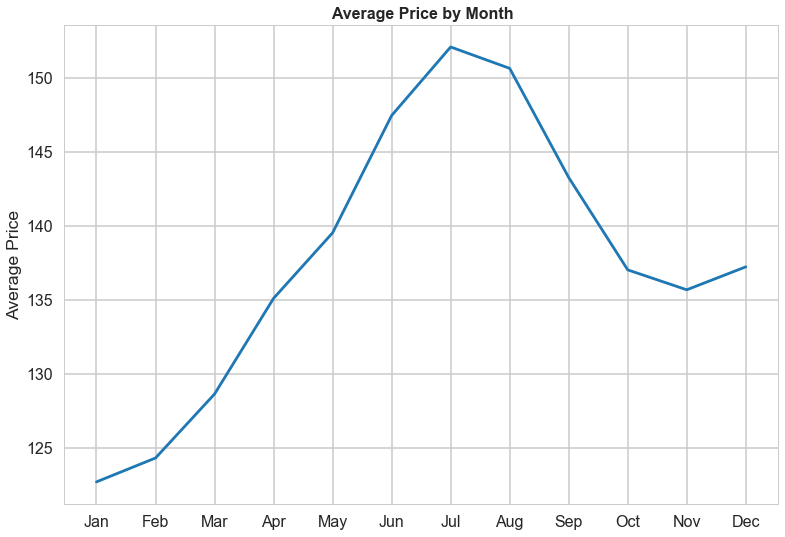

In [30]:

plot_answers('month', 'average_price')

#### 

The average price at the busiest time of airbnb listings in Seattle is around $122. As the month goes by, the average prices seem to rise. However, from July, when the prices are at the peak and when occupancy begins to decline, we also see a steady decrease in prices.

This begs the question, Is there a correlation between prices and  
occpancy. We can quickly use a scatterplot to visualize this. 

However, as the data is too large we will use a small sample size




In [31]:
sample_new_calendar = new_calendar.sample(150)

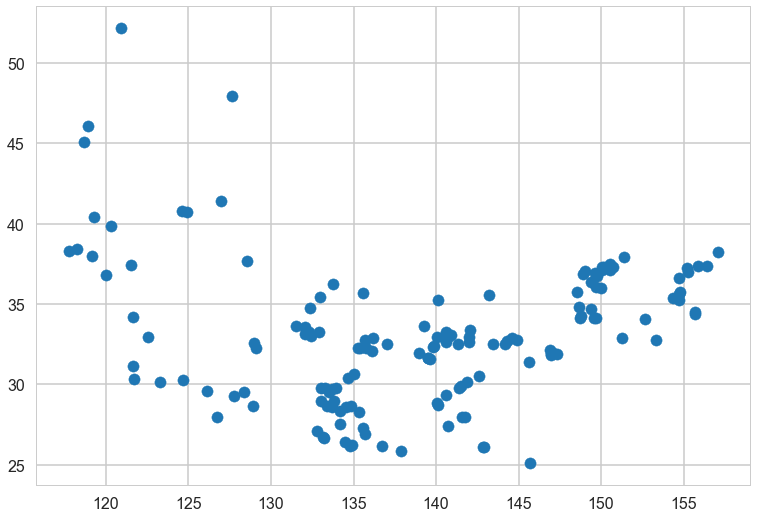

In [32]:
plt.scatter(sample_new_calendar['average_price'], sample_new_calendar['occupancy'])

#### 
Is there some sort of curvlinear relationship between these two 
variables? Further statistical analysis will shed more light on our question.
For now, let's take it up a notch to see the busiest time of the week 
and how prices flunctuate during the week

#### When is the busiest time of the week ?

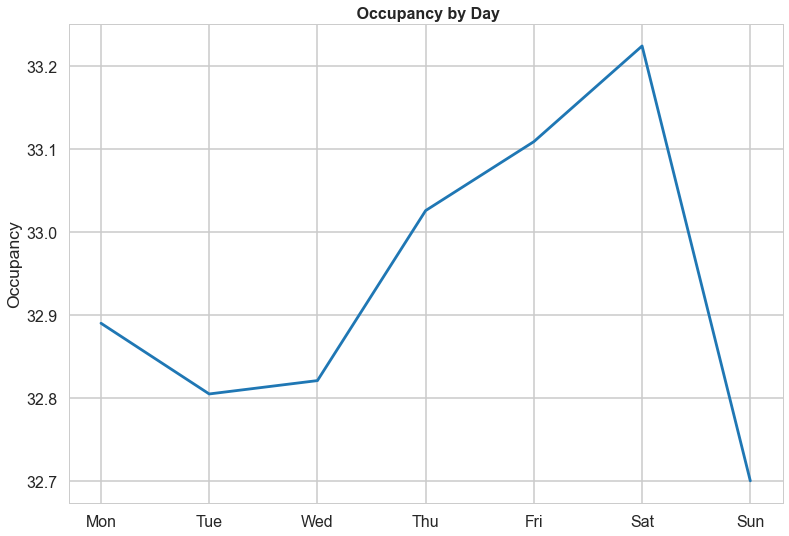

In [33]:
plot_answers('day', 'occupancy') 

#### 
The busiest time of the week is between Wednesday and Saturday, with the peak being saturday 

#### How are prices during the week ?

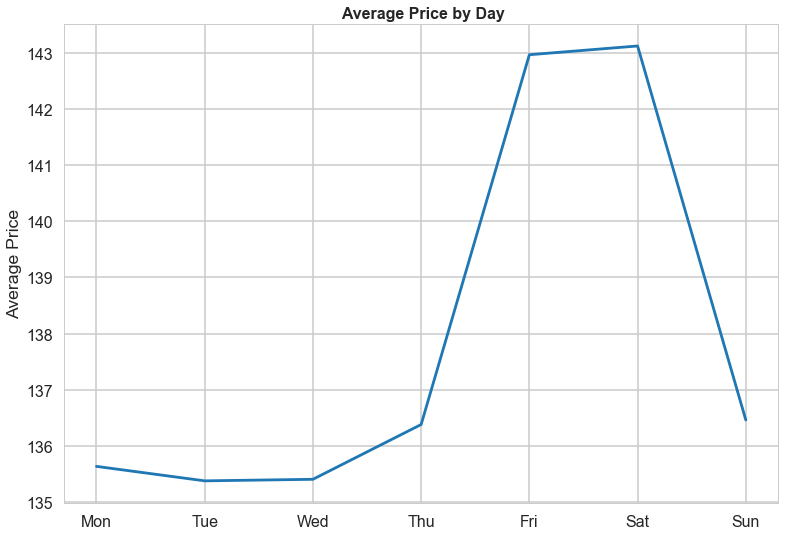

In [34]:
plot_answers('day', 'average_price') 

#### 
The prices follow a similar trend to that of occupancy, with prices rising from Thursday and peaking on Saturday, 
followed by a price drop on Sunday 

#### 
Going back to determine the correlation between prices and occupancy for Airbnb in Seattle 



In [35]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [36]:
#Pearson's correlation coefficient

corr = pearsonr(sample_new_calendar['average_price'], sample_new_calendar['occupancy'])
print(corr)

(-0.01747603381531711, 0.8319022335611168)


#### 
This shows a very weak negative linear relationship.
However, the sample size might not be a good representation of the 
entire population. 

Using a correlation Matrix to check the correlation,

<AxesSubplot:>

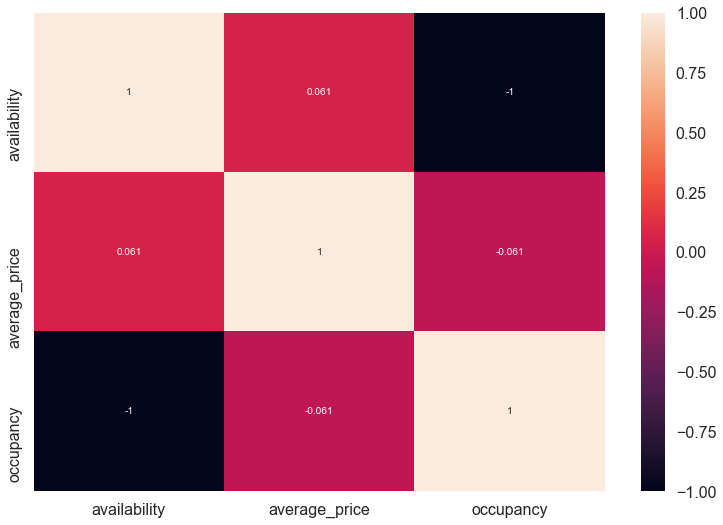

In [37]:
corrMatrix = new_calendar.corr()
sns.heatmap(corrMatrix, annot=True)

From the correlation Matrix, we can see that there is almost no linear correlation between average prices and occupancy.

### 2. Which neighborhoods are the most expensive ?

To determine this, we will use the Listings data set. 

In [38]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [39]:
new_listings = listings[['id', 'neighbourhood_cleansed', 'zipcode', 'price']]
new_listings.sample(5)

id     neighbourhood_cleansed zipcode  price
163    227636              West Woodland   98107  120.0
2345  3726391                Seward Park   98118  160.0
1552  6916167  Central Business District   98101  300.0
1877  4378803                    Genesee   98126  139.0
2875  7054225                   Broadway   98122  200.0

let's take a look at the price distribution

Text(0.5, 1.0, 'Boxplot of listings Prices')

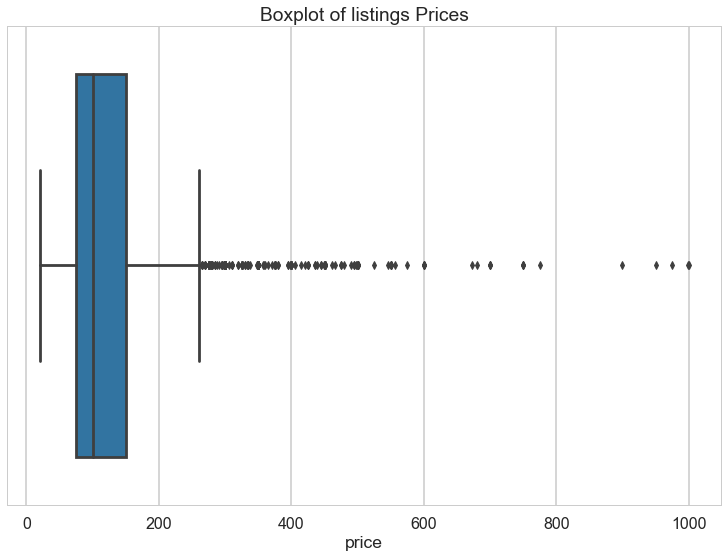

In [40]:
sns.boxplot(new_listings.price).set_title(
    'Boxplot of listings Prices')

In [41]:
new_listings['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

From the describtion of our select data, the prices of airbnb listings in Seattle ranges from 20 to 1000. The median price being 100 and the mean price $127. This discrepancy can be attributable to highly priced listings in Seattle (outliers). Moving on, we will remove the outliers and use listings with prices less than 600. Also, we will be using median as opposed to mean to get the central tendency of the price distribution in neighborhoods.

In [42]:
#determining how many outliers in between 600-1000

print('There are {} listings in the 600 to 1000 price bracket'.format(
    len(listings[listings.price >= 600])))

There are 18 listings in the 600 to 1000 price bracket


In [43]:
# Removing top outliers 
listings = listings[listings.price < 600]

Text(0.5, 1.0, 'Histogram of listings price')

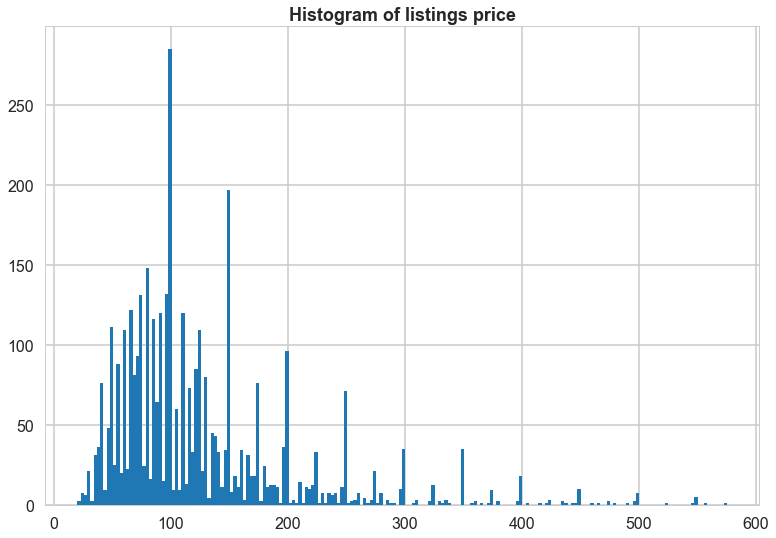

In [44]:
# Visualizing the price distribution after removing top outliers
listings.price.hist(bins=200)
plt.title('Histogram of listings price',
          fontsize=18, fontweight='bold')

### Determining which neighborhoods have the most listings

We will get the number of listings by neighborhood and plot the top neighborhoods by the number of listings. 

In [45]:
#how many neighborhoods in the listings data?

print('There are {} neighborhoods in the listings data'.format(
    len(listings.neighbourhood_cleansed.unique())))

There are 87 neighborhoods in the listings data


In [46]:
def neighborhood_plot(df, groupby_col, agg_col, plot_type, top_k=10):
    '''
    INPUT:
    df - the dataset to be used 
    groupby_col - column name to be used for grouping values
    agg_col - column name for values to be grouped
    plot_type - the plot type to be used for the visualization
    top_k - Nos of top grouped values to be displayed in the plot

    OUTPUT:
    Plot to display listings count by neighborhoods 

    '''

    if plot_type == 'count':

        # Count plot for top neighborhoods based on listing counts
        if agg_col == 'id':
            grouped_df = df.groupby(groupby_col)[agg_col].count()
            order_index = grouped_df.sort_values(ascending=False).index[:top_k]
            splot = sns.countplot(x=groupby_col, data=df,
                                  palette="Set1", order=order_index)

            for p in splot.patches:
                splot.annotate(format(p.get_height(), '.0f'), (p.get_x()+p.get_width()/2., p.get_height()),
                               rotation=90, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

            plt.xlabel('Neighborhood')
            plt.ylabel('Listings count')
            plt.title('Top neighborhoods based on listing counts',
                      fontsize=18, fontweight='bold')

        # Count plot for top neighborhoods price distribution
        elif agg_col == 'price_bins':
            bins = [0, 101, 201, 301, 401, 501, 1000]
            group = ['1-100', '101-200', '201-300',
                     '301-400', '400-500', '500+']

            df['price_bins'] = pd.cut(df['price'], bins, labels=group)

            grouped_df = df.groupby(groupby_col)['price'].median()
            order_index = grouped_df.sort_values(ascending=False).index[:top_k]
            splot = sns.countplot(x=groupby_col, data=df, hue='price_bins',
                                  orient='h', palette="Set1", order=order_index)
            for p in splot.patches:
                splot.annotate(format(p.get_height(), '.0f'), (p.get_x()+p.get_width()/2., p.get_height()),
                               rotation=90, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

            plt.xlabel('Neighborhood')
            plt.ylabel('Price bins count')
            plt.title('Top neighborhoods price distribution',
                      fontsize=18, fontweight='bold')
            plt.legend(loc='upper right')

    # Box plot for top neighborhoods based on price
    elif plot_type == 'box':
        grouped_df = df.groupby(groupby_col)[agg_col].median()
        order_index = grouped_df.sort_values(ascending=False).index[:top_k]
        sns.boxplot(x=groupby_col, y=agg_col, data=df,
                    palette="Set1", order=order_index)

        plt.xlabel('Neighborhood')
        plt.ylabel('Price')
        plt.title('Top neighborhoods based on listing prices',
                  fontsize=18, fontweight='bold')

    plt.xticks(
        rotation=45,
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large'
    )

neighborhood_plot(listings, 'neighbourhood_cleansed', 'id', 'count', top_k=10)

From the chart above, we see that Broadway, Belltown and Wallingford are the top 3 neighborhoods based on the count of listings. However, this shows only half the picture, because some neighborhoods could have bigger counts due to a larger sizes. To better understand top neighborhoods, we will look at listing density to see the spread of listings in a neighborhood. 

To optimally visualize this, we will plot the geographic coordinates of the listings on a map.

In [47]:
def plot_top_neighborhood_locations(df, groupby_col):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    Map displaying the listings locations for top neighborhoods

    '''
    # Seattle latitude and longitude 
    latitude = 47.6062
    longitude = -122.3321

    # Differentiating neighborhoods in the map
    color_list = ['red', 'blue', 'gray', 'darkred', 'lightgreen',
                  'orange', 'black', 'cadetblue', 'darkgreen', 'purple']

    # filtering the listings data for only top 10 neighbourhoods
    grouped_df = df.groupby(groupby_col)['id'].count()
    top_nbrhd_list = list(grouped_df.sort_values(ascending=False).index[:10])
    top_nbrhd = listings[listings[groupby_col].isin(top_nbrhd_list)]

    # creating color mapping for each neighborhood
    colormap = dict(zip(top_nbrhd_list, color_list))

    # creating the map and visualizing it
    seattle_map = folium.Map(location=[latitude, longitude], zoom_start=12)

    # instantiate a feature group for the incidents in the dataframe
    incidents = folium.map.FeatureGroup()

    # looping through the listings and adding each to the incidents feature group
    for lat, lng, nbrhd in zip(top_nbrhd.latitude, top_nbrhd.longitude, top_nbrhd[groupby_col]):
        if nbrhd in colormap:
            nbrhd_color = colormap[nbrhd]
            incidents.add_child(
                folium.vector_layers.CircleMarker(
                    [lat, lng],
                    radius=1.0,  # define how big you want the circle markers to be
                    color=nbrhd_color,
                    fill=False,
                    popup=nbrhd,
                    fill_color='blue',
                    fill_opacity=0.05
                )
            )

   # adding incidents to the map
    seattle_map.add_child(incidents)
    
   # adding legends to the map
    if groupby_col == 'neighbourhood_cleansed':
        image_file = 'https://github.com/OmoyeniO/Analyzing-Seattle-Airbnb-Data-Udacity-Data-Science-Project-/blob/main/Seattle%20neighborhood%201.png'
    else:
        image_file = 'https://github.com/OmoyeniO/Analyzing-Seattle-Airbnb-Data-Udacity-Data-Science-Project-/blob/main/Seattle%20neighborhood%202.png'

    folium.plugins.FloatImage(image_file, bottom=55,
                              left=70).add_to(seattle_map)

    return seattle_map

In [48]:
plot_top_neighborhood_locations(listings, 'neighbourhood_cleansed')


Based on listing counts, looking at the top 3 neighborhoods, listing density is more concentrated near Broadway and Belltown. However, in Wallington listing is more spread out. 

The areas in and around Broadway and Belltown seem to be where most of the listings are located. To be certain, we will plot the top neighborhood groups.

In [49]:
plot_top_neighborhood_locations(listings, 'neighbourhood_group_cleansed')


It is indeed correct. Neighborhood groups Capitol Hill, Downtown which contain Broadway and Belltown respectively are among the top three neighborhood groups based on listing counts.

### Determining which neighborhoods are the most expensive

To determine the most expensive neighborhoods, we will look at average prices of different neighborhoods, where the neighborhoods have at least 60 listings.

In [50]:
# Filtering the data for only those neighbourhoods that has at least 60 listings.

nbrhd_grouped_df = listings.groupby('neighbourhood_cleansed')['id'].count()
top_nbrhd_list = list(
    nbrhd_grouped_df[nbrhd_grouped_df > 60].sort_values(ascending=False).index)
top_nbrhd = listings[listings['neighbourhood_cleansed'].isin(top_nbrhd_list)]

print("{} neighbourhoods have at least 60 listings" .format(len(top_nbrhd_list)))

19 neighbourhoods have at least 60 listings


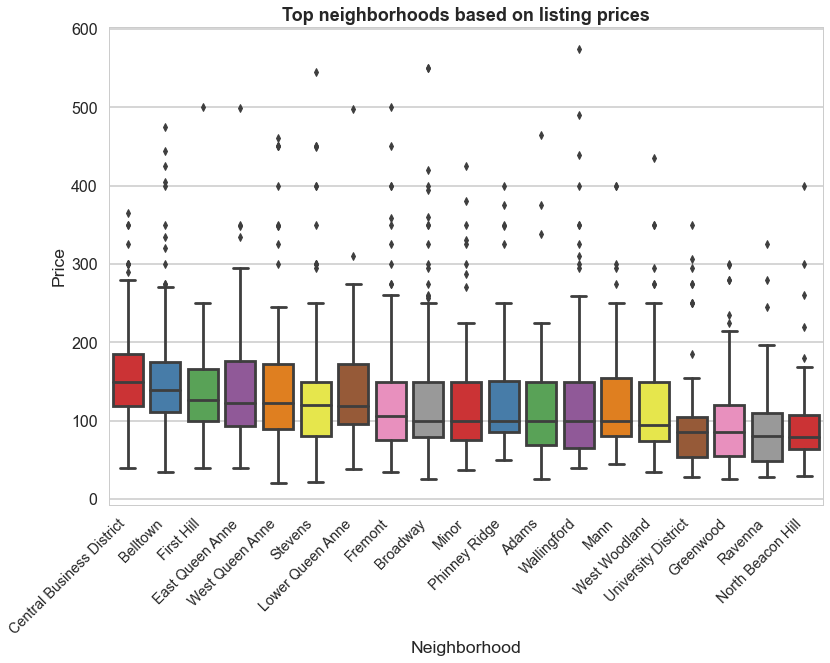

In [51]:
neighborhood_plot(top_nbrhd, 'neighbourhood_cleansed', 'price', 'box',19)


Based on average pricing, Central Business District is the most expensive, and North Beacon Hill is the cheapest neighborhood. To look deeper into this, we will analyze the price distribution in each of these neighborhoods.

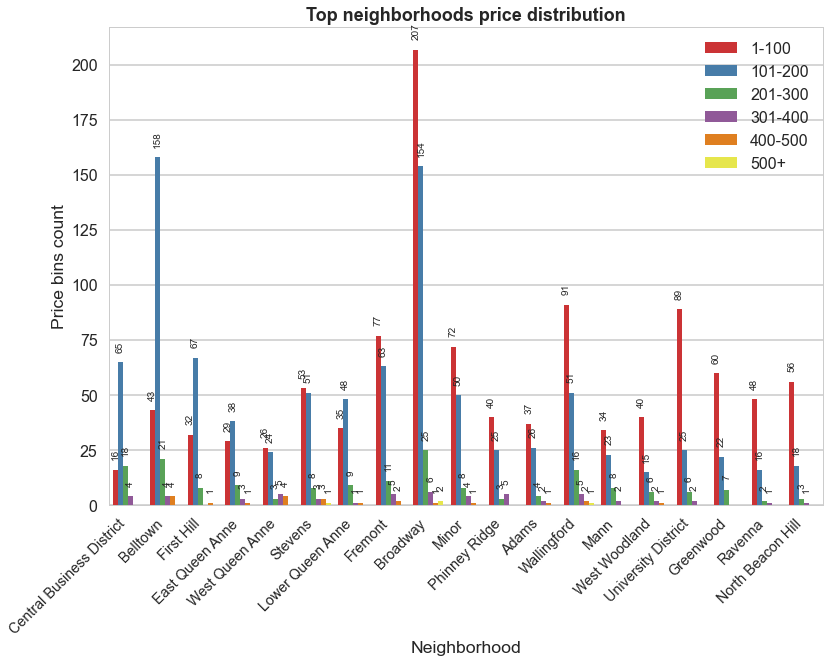

In [52]:
neighborhood_plot(top_nbrhd, 'neighbourhood_cleansed', 'price_bins', 'count', 25)


The more expensive neighborhoods have most of their listings in the 101–200 price range, whereas, the rest have most of their listings in the 1–100 price range. Broadway, which is somewhere around the middle, has almost the same no of listings as Belltown in the 101–200 price range. But, that is offset by even higher number of listings in the 1–100 price range

## 3. Which Listing Features have an effect on Price?

The goal here is to build a predictive model using different attributes of the listings. We will train a model on the listing data and find out the most important features that have an impact on the model. 

First step is to clean up the data, determine and evaluate which features we can use for model building.

#### Data Preperation

Listings dataset has 92 columns. Not all of them are useful in building machine learning models. We will ignore columns like listing id, name,summary etc that fall into this category 

In [53]:
features = ['cancellation_policy', 'is_location_exact', 'accommodates', 'reviews_per_month', 'property_type', 'price',
            'host_total_listings_count', 'extra_people', 'calculated_host_listings_count', 'guests_included',
            'review_scores_rating', 'host_response_time', 'number_of_reviews', 'host_is_superhost', 'room_type',
            'instant_bookable', 'amenities', 'host_identity_verified', 'host_has_profile_pic', 'security_deposit',
            'host_listings_count', 'requires_license', 'neighbourhood_group_cleansed', 'neighbourhood_cleansed',
            'minimum_nights', 'bathrooms', 'require_guest_phone_verification', 'cleaning_fee']

In [54]:
data = listings[features].copy()
data.head(5)

cancellation_policy is_location_exact  accommodates  reviews_per_month  \
0            moderate                 t             4               4.07   
1              strict                 t             4               1.48   
3            flexible                 t             3                NaN   
4              strict                 t             6               0.89   
5              strict                 t             2               2.45   

  property_type  price  host_total_listings_count extra_people  \
0     Apartment   85.0                        3.0        $5.00   
1     Apartment  150.0                        6.0        $0.00   
3     Apartment  100.0                        1.0        $0.00   
4         House  450.0                        2.0       $15.00   
5         House  120.0                        1.0       $30.00   

   calculated_host_listings_count  guests_included  ...  host_has_profile_pic  \
0                               2                2  ...                     t   
1                               6                1  ...                     t   
3                               1                1  ...                     t   
4                               1                6  ...                     t   
5                               1                1  ...                     t   

  security_deposit  host_listings_count requires_license  \
0              NaN                  3.0                f   
1          $100.00                  6.0                f   
3              NaN                  1.0                f   
4          $700.00                  2.0                f   
5              NaN                  1.0                f   

  neighbourhood_group_cleansed neighbourhood_cleansed minimum_nights  \
0                   Queen Anne        West Queen Anne              1   
1                   Queen Anne        West Queen Anne              2   
3                   Queen Anne        West Queen Anne              1   
4                   Queen Anne        West Queen Anne              1   
5                   Queen Anne        West Queen Anne              1   

  bathrooms require_guest_phone_verification cleaning_fee  
0       1.0                                f          NaN  
1       1.0                                t       $40.00  
3       1.0                                f          NaN  
4       2.0                                f      $125.00  
5       1.0                                f       $40.00  

[5 rows x 28 columns]

The data needs to be cleaned, we can see that some price columns have the dollar sign (i.e- extra_people column, security_deposit column etc). Also, there are some missing values in the dataset.

In [55]:
data.cleaning_fee = data.cleaning_fee.str.replace('$', '').str.replace(',', '')
data.cleaning_fee = data.cleaning_fee.astype(float)

data.security_deposit = data.security_deposit.str.replace(
    '$', '').str.replace(',', '')
data.security_deposit = data.security_deposit.astype(float)

data.extra_people = data.extra_people.str.replace('$', '').str.replace(',', '')
data.extra_people = data.extra_people.astype(float)

In [56]:
#Dealing with missing values 

# Diplay columns with missing values percentage
data.isnull().mean().sort_values(ascending=False)[:15]*100

security_deposit                51.289474
cleaning_fee                    27.052632
review_scores_rating            17.000000
reviews_per_month               16.473684
host_response_time              13.657895
bathrooms                        0.421053
host_listings_count              0.052632
host_is_superhost                0.052632
host_has_profile_pic             0.052632
host_identity_verified           0.052632
host_total_listings_count        0.052632
property_type                    0.026316
neighbourhood_group_cleansed     0.000000
minimum_nights                   0.000000
requires_license                 0.000000
dtype: float64

We will go ahead and drop some of the columns that have more than 40% missing values.

In [57]:
def drop_missing_value_cols(df, missing_thres=0.4):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    new_df - a dataframe with missing values columns dropped
    '''
    # Create a copy to prevent modifying slices of original dataframe
    new_df = df.copy()

    # Drop columns having more than a certain percentage of missing values
    missing_thres = len(new_df) - (len(new_df) * missing_thres)
    new_df = new_df.dropna(thresh=missing_thres, axis=1)

    return new_df

missing_thres = 0.4
data_clean = drop_missing_value_cols(data, missing_thres)

In [58]:
data_clean.head(5)

cancellation_policy is_location_exact  accommodates  reviews_per_month  \
0            moderate                 t             4               4.07   
1              strict                 t             4               1.48   
3            flexible                 t             3                NaN   
4              strict                 t             6               0.89   
5              strict                 t             2               2.45   

  property_type  price  host_total_listings_count  extra_people  \
0     Apartment   85.0                        3.0           5.0   
1     Apartment  150.0                        6.0           0.0   
3     Apartment  100.0                        1.0           0.0   
4         House  450.0                        2.0          15.0   
5         House  120.0                        1.0          30.0   

   calculated_host_listings_count  guests_included  ...  \
0                               2                2  ...   
1                               6                1  ...   
3                               1                1  ...   
4                               1                6  ...   
5                               1                1  ...   

   host_identity_verified host_has_profile_pic  host_listings_count  \
0                       t                    t                  3.0   
1                       t                    t                  6.0   
3                       t                    t                  1.0   
4                       t                    t                  2.0   
5                       t                    t                  1.0   

  requires_license neighbourhood_group_cleansed neighbourhood_cleansed  \
0                f                   Queen Anne        West Queen Anne   
1                f                   Queen Anne        West Queen Anne   
3                f                   Queen Anne        West Queen Anne   
4                f                   Queen Anne        West Queen Anne   
5                f                   Queen Anne        West Queen Anne   

  minimum_nights bathrooms require_guest_phone_verification  cleaning_fee  
0              1       1.0                                f           NaN  
1              2       1.0                                t          40.0  
3              1       1.0                                f           NaN  
4              1       2.0                                f         125.0  
5              1       1.0                                f          40.0  

[5 rows x 27 columns]

We can see that there are still some missing values, hence we will go ahead and carry out data imputation to take care of the missing values

In [59]:
# Identify numerical features
num_cols = data_clean.select_dtypes(exclude='object').columns
# Identify categorical columns
cat_cols = data_clean.select_dtypes(include='object').columns

# Impute numerical features with median and categorical features with mode
data_clean[cat_cols] = data_clean[cat_cols].apply(
    lambda col: col.fillna(col.mode()[0]))
data_clean[num_cols] = data_clean[num_cols].apply(
    lambda col: col.fillna(col.median()))

For the amenities column we will create a new feature that contains no. of amenities provided under the listing.


In [60]:
data_clean['number_of_amenities'] = data_clean['amenities'].apply(
    lambda x: len(x.replace('{', '').replace('}', '').split(',')))

##### Feature Selection

In [61]:
def get_low_var_cols(df, thres=90):
    '''
    INPUT:
    df -the dataframe to be used 
    thres - percentage threshold value to identify low variability columns
    OUTPUT:
    low_var_cols - list of low variability columns identified 
    '''
    low_var_cols = []

    for col in df.columns:
        percent_count = df[col].value_counts()/len(df)*100
        if percent_count.max() > thres:
            low_var_cols.append(col)

    return low_var_cols

In [62]:
# Identifying columns that has same data across 90% of the rows
variance_thres = 90
low_var_cols = get_low_var_cols(data_clean, variance_thres)
print('{} are columns with same data across 90% of the rows'.format(
    str(low_var_cols)[1:-1]))

'host_has_profile_pic', 'requires_license', 'require_guest_phone_verification' are columns with same data across 90% of the rows


In [63]:
# Dropping id column and low variance columns
drop_cols = low_var_cols
data_clean = data_clean.drop(drop_cols, axis=1)

Now we are going to use a heatmap to select numeric features based on how they correlate with the price.

<AxesSubplot:>

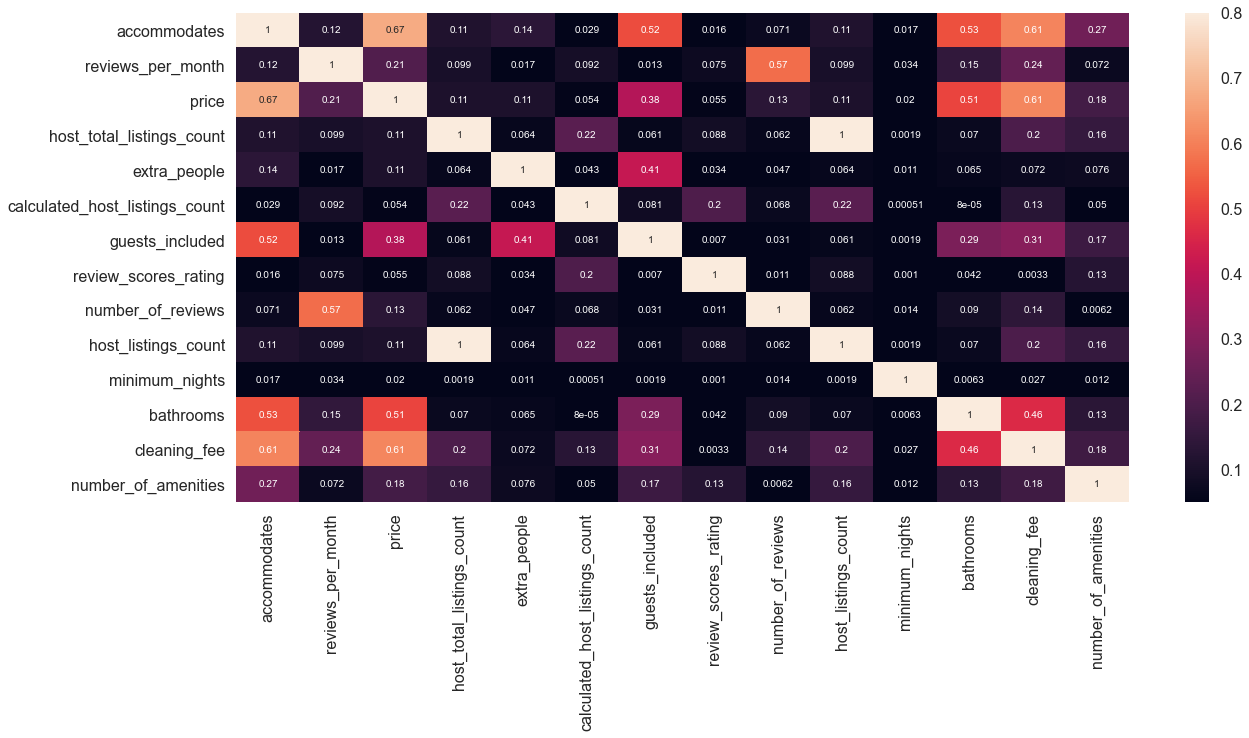

In [64]:
corr_matrix = data_clean.corr()
corr_matrix = abs(corr_matrix)
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr_matrix, vmax=0.8, vmin=0.05, annot=True)

In [65]:
corr_matrix['price'].sort_values(ascending=False)


price                             1.000000
accommodates                      0.674292
cleaning_fee                      0.611350
bathrooms                         0.508671
guests_included                   0.382098
reviews_per_month                 0.208632
number_of_amenities               0.183271
number_of_reviews                 0.132412
host_total_listings_count         0.108460
host_listings_count               0.108460
extra_people                      0.107256
review_scores_rating              0.054878
calculated_host_listings_count    0.054235
minimum_nights                    0.019608
Name: price, dtype: float64

The number of correlated columns is small, we will consider a correlation coefficient threshold of 0.1.

For categorical features we will consider only those columns that have a maximum of 15 categorical values. 

In [66]:
def select_cat_features(df, cols_list, unique_thres=15):
    '''
    INPUT:
    df - the dataframe to be used 
    cols_list - list of columns where features will be selected from 
    unique_thres - float value for threshold of no of unique values in categorical features

    OUTPUT:
    selected_features - list of categorical columns selected 
    '''
    selected_features = []

    # Select categorical columns based on no of unique values threshold
    for col in cols_list:
        if len(df[col].unique()) <= unique_thres:
            selected_features.append(col)

    return selected_features

In [67]:
def select_features(df, unique_thres=15, corr_thres=0.1):
    '''
    INPUT:
    df - the dataframe to be used
    unique_thres -  float value for threshold of no of unique values in categorical features
    corr_thres - a float value representing correlation coefficient threshold for identifying the 
               correlated columns

    OUTPUT:
    selected_features - list of selected featuresfor model building
    selected_num_features - list of selected numerical features for model building
    selected_cat_features - list of selected categorical features for model building
    '''

    # Identify numerical features
    num_cols = df.select_dtypes(exclude='object').columns
    

    # Select numerical columns based on correlation coefficient threshold
    corr = df[num_cols].corr()
    corr_matrix = corr.abs()
    selected_num_features = corr_matrix[(
        corr_matrix['price'] > corr_thres)]['price'].index.tolist()

    # Identify categorical columns
    cat_cols = df.select_dtypes(include='object').columns
    
    # Select categorical columns based on no of unique values threshold
    selected_cat_features = select_cat_features(df, cat_cols, unique_thres)

    selected_features = selected_num_features + selected_cat_features

    return selected_features, selected_num_features, selected_cat_features

In [68]:
# Getting the list of selected features

selected_cols, num_cols, cat_cols = select_features(data_clean, 20, 0.1)

In [69]:
print("Selected numerical features are:", str(num_cols)[1:-1])


Selected numerical features are: 'accommodates', 'reviews_per_month', 'price', 'host_total_listings_count', 'extra_people', 'guests_included', 'number_of_reviews', 'host_listings_count', 'bathrooms', 'cleaning_fee', 'number_of_amenities'


In [70]:
print("Selected categorical features are:", str(cat_cols)[1:-1])


Selected categorical features are: 'cancellation_policy', 'is_location_exact', 'property_type', 'host_response_time', 'host_is_superhost', 'room_type', 'instant_bookable', 'host_identity_verified', 'neighbourhood_group_cleansed'


We will apply log transformation to transfrom skewed data to approximately conform to normality. This is because many machine learning algorithms work better when features are on a similar scale and are normally distributed.  

For simplicity, we will perfrom scalling on the data from 0-1 range using minmaxscaler.

In [71]:
def transform_data(df, num_cols, cat_cols):
    '''
    INPUT:
    df - dataframe to be used
    num_cols- list of numerical features selected for model building
    cat_cols - list of categorical features selected for model building
    unique_thres - float value for threshold of nos of unique values in categorical features

    OUTPUT:
    transformed_df - dataframe after data preprocessing
    '''

    transformed_df = df.copy()

    for col in cat_cols:
        transformed_df[col] = transformed_df[col].astype('category')
        transformed_df = pd.concat([transformed_df.drop(
            col, axis=1), pd.get_dummies(transformed_df[col], prefix=col)], axis=1)

    # Apply log transformation on numeric features. To take into account zero values, we will add 1 before taking log.
    transformed_df[num_cols] = transformed_df[num_cols].apply(
        lambda x: np.log(x+1))

    # Scale numerical predictor columns
    num_cols.remove('price')
    scaler = MinMaxScaler()
    transformed_df[num_cols] = scaler.fit_transform(transformed_df[num_cols])

    return transformed_df

### Modeling Building and Evaluation

In [72]:
def train_and_test(df, model, test_size=0.2):
    '''
    INPUT:
    df - dataframe to be used 

    OUTPUT:
    model - trained model
    '''
    target = transformed_df['price']
    features = transformed_df.copy().drop('price', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=42)

    model.fit(X_train, y_train)  # fit the model
    y_pred = model.predict(X_test)  # make prediction on test set
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE from {0}:{1}".format(model, mae))
    
    
    # Get actual price values
    pred = np.round(np.exp(y_pred) + 1, 1)
    actual = np.round(np.exp(y_test) + 1, 1)
    
    # Plot Predicted vs actual values
    plt.scatter(actual.to_numpy(), pred)
    plt.title('Predicted vs. Actual Price', fontsize=18, fontweight='bold')
    plt.xlabel('Actual Listing Price')
    plt.ylabel('Predicted Listing Price')
    plt.show()

    return model

In [73]:
# transforming the data to work better with machine learning algorithms
transformed_df = transform_data(data_clean[selected_cols], num_cols, cat_cols)

In [74]:
transformed_df.head(5)

accommodates  reviews_per_month     price  host_total_listings_count  \
0      0.428160           0.627210  4.454347                   0.125401   
1      0.428160           0.347512  5.017280                   0.226644   
3      0.323891           0.356862  4.615121                   0.000000   
4      0.585385           0.241246  6.111467                   0.073355   
5      0.189464           0.476634  4.795791                   0.000000   

   extra_people  guests_included  number_of_reviews  host_listings_count  \
0      0.313952         0.396241           0.866017             0.125401   
1      0.000000         0.250000           0.613986             0.226644   
3      0.000000         0.250000           0.000000             0.000000   
4      0.485813         0.701839           0.594414             0.073355   
5      0.601703         0.250000           0.468964             0.000000   

   bathrooms  cleaning_fee  ...  neighbourhood_group_cleansed_Interbay  \
0   0.315465      0.546584  ...                                      0   
1   0.315465      0.490840  ...                                      0   
3   0.315465      0.546584  ...                                      0   
4   0.500000      0.777586  ...                                      0   
5   0.315465      0.490840  ...                                      0   

   neighbourhood_group_cleansed_Lake City  \
0                                       0   
1                                       0   
3                                       0   
4                                       0   
5                                       0   

   neighbourhood_group_cleansed_Magnolia  \
0                                      0   
1                                      0   
3                                      0   
4                                      0   
5                                      0   

   neighbourhood_group_cleansed_Northgate  \
0                                       0   
1                                       0   
3                                       0   
4                                       0   
5                                       0   

   neighbourhood_group_cleansed_Other neighborhoods  \
0                                                 0   
1                                                 0   
3                                                 0   
4                                                 0   
5                                                 0   

   neighbourhood_group_cleansed_Queen Anne  \
0                                        1   
1                                        1   
3                                        1   
4                                        1   
5                                        1   

   neighbourhood_group_cleansed_Rainier Valley  \
0                                            0   
1                                            0   
3                                            0   
4                                            0   
5                                            0   

   neighbourhood_group_cleansed_Seward Park  \
0                                         0   
1                                         0   
3                                         0   
4                                         0   
5                                         0   

   neighbourhood_group_cleansed_University District  \
0                                                 0   
1                                                 0   
3                                                 0   
4                                                 0   
5                                                 0   

   neighbourhood_group_cleansed_West Seattle  
0                                          0  
1                                          0  
3                                          0  
4                                          0  
5                                          0  

[5 rows x 62 columns]

MAE from LGBMRegressor():0.22792368550304318


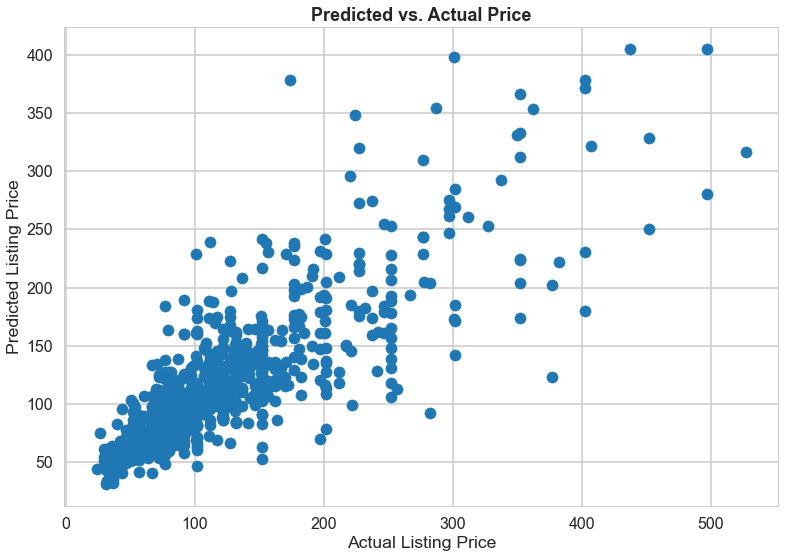

In [75]:
model = LGBMRegressor()
trained_model = train_and_test(transformed_df, model)

The MAE from our model is:0.228 which is good but can be better. 

One of the things we'll notice from the plot is that the spread of the actual and predicted prices is quite low from below 200.  This can be considered a good thing as most of the listing prices are below 200. However, more work can be done on the model to optimize it. 

For example: i) We can try different other ways of handling missing values 
             ii) Increase the corr coef threshold, which will inturn increase the list of numerical features used
             iii) Hyper parameter tuning to improve model accuracy


#### Now let's look at how these features in the trained model are important in predicting a listing price.

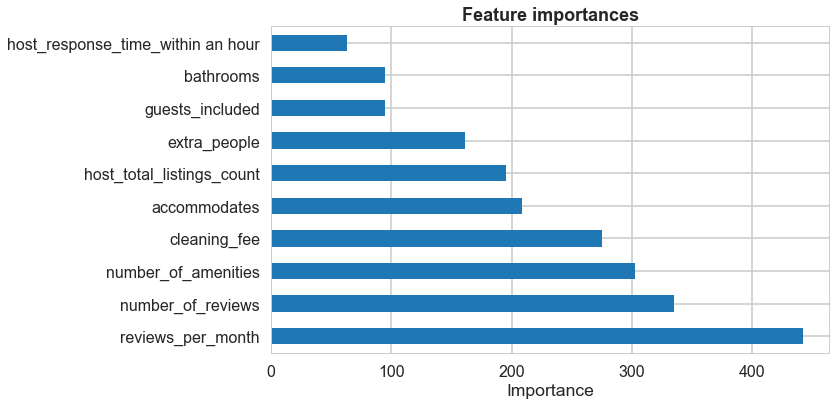

In [76]:
feat_imp = pd.Series(trained_model.feature_importances_,
                     index=transformed_df.columns.drop('price'))
feat_imp.nlargest(10).plot(kind='barh', figsize=(10, 6))
plt.xlabel('Importance')
plt.title("Feature importances", fontsize=18, fontweight='bold')
plt.show()

Reviews per monthly, number of reviews, number of amenities, cleaning fee, and accommodates seem to be most important features in listing price prediction. We can also note that accommodates, extra people, guests included and bathrooms are all related to the size of the property. Thus size of the property is a very important feature in determining listing price, along with reviews and cleaning fee.

#### Let us look at how cancelation policies affect how properties get booked.

### 4. Does Cancelatation policies have an effect on booking ?

In [77]:
#selecting columns we need

cancel_price = listings[['id', 'cancellation_policy', 'price']]
cancel_price.rename(columns = {'id':'listing_id'},inplace = True)
cancel_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3800 entries, 0 to 3817
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   listing_id           3800 non-null   int64  
 1   cancellation_policy  3800 non-null   object 
 2   price                3800 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 118.8+ KB


In [78]:
cancel_price.head()

listing_id cancellation_policy  price
0      241032            moderate   85.0
1      953595              strict  150.0
3     7421966            flexible  100.0
4      278830              strict  450.0
5     5956968              strict  120.0

In [79]:
#creating availability and occupancy columns from calendar data and merging with selected columns from listing data

calendar_listings = calendar.groupby('listing_id')['available'].mean().reset_index()


In [80]:
calendar_listings['occupancy'] = (1- calendar_listings['available'])* 100

calendar_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   listing_id  3818 non-null   int64  
 1   available   3818 non-null   float64
 2   occupancy   3818 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 89.6 KB


In [81]:
calendar_listings.head()

listing_id  available  occupancy
0        3335   0.846575  15.342466
1        4291   1.000000   0.000000
2        5682   0.846575  15.342466
3        6606   1.000000   0.000000
4        7369   0.145205  85.479452

In [82]:
merging_df = pd.merge(cancel_price,calendar_listings, how ='left', on = 'listing_id')

In [83]:
merging_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3800 entries, 0 to 3799
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   listing_id           3800 non-null   int64  
 1   cancellation_policy  3800 non-null   object 
 2   price                3800 non-null   float64
 3   available            3800 non-null   float64
 4   occupancy            3800 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 178.1+ KB


In [84]:
merging_df.head()

listing_id cancellation_policy  price  available  occupancy
0      241032            moderate   85.0   0.947945   5.205479
1      953595              strict  150.0   0.797260  20.273973
2     7421966            flexible  100.0   0.391781  60.821918
3      278830              strict  450.0   1.000000   0.000000
4     5956968              strict  120.0   0.827397  17.260274

In [85]:
merging_df.cancellation_policy.unique()

array(['moderate', 'strict', 'flexible'], dtype=object)

In [86]:
#converting canelation policy to dummy variables


merging_df['dummy_cancel_policy']= merging_df['cancellation_policy'].map(dict(strict=0, flexible=1,moderate=2))

In [87]:
merging_df.sample(5)

listing_id cancellation_policy  price  available  occupancy  \
2119     6644628            moderate  150.0   1.000000   0.000000   
1837     6902752            moderate   75.0   0.961644   3.835616   
471      5405643            moderate   89.0   0.857534  14.246575   
1150     7203765            flexible  110.0   0.405479  59.452055   
1409     3033913              strict  105.0   0.183562  81.643836   

      dummy_cancel_policy  
2119                    2  
1837                    2  
471                     2  
1150                    1  
1409                    0

Now that we have the data that we need selected, Firstly lets try to understand listings and cancelation policy in Seattle

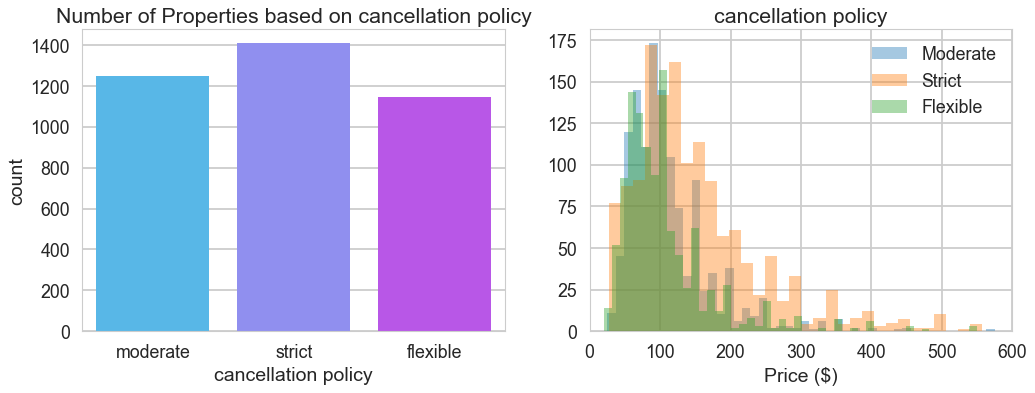

In [88]:
#Understanding the distribution of cancelation policy 

fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=80)
sns.countplot(x = 'cancellation_policy', data = merging_df, 
              palette = 'cool', ax=axs[0]).set_title("Number of Properties based on cancellation policy")
axs[0].set_xlabel('cancellation policy')

#Understanding Price distribution accross each policy type.
sns.distplot(merging_df[merging_df.cancellation_policy == 'moderate']['price'],
             kde=False, ax=axs[1], label='Moderate')
sns.distplot(merging_df[merging_df.cancellation_policy == 'strict']['price'],
             kde=False, ax=axs[1], label='Strict')
sns.distplot(merging_df[merging_df.cancellation_policy == 'flexible']['price'],
             kde=False, ax=axs[1], label='Flexible')

axs[1].set_xlim(0, 600)
axs[1].set_title('cancellation policy')
axs[1].set_xlabel('Price ($)')
axs[1].legend()




Listings with Strict cancellation policies are the most listed in Seattle. However, moderate cancellation policies have the maximum range of listing price. 

<AxesSubplot:>

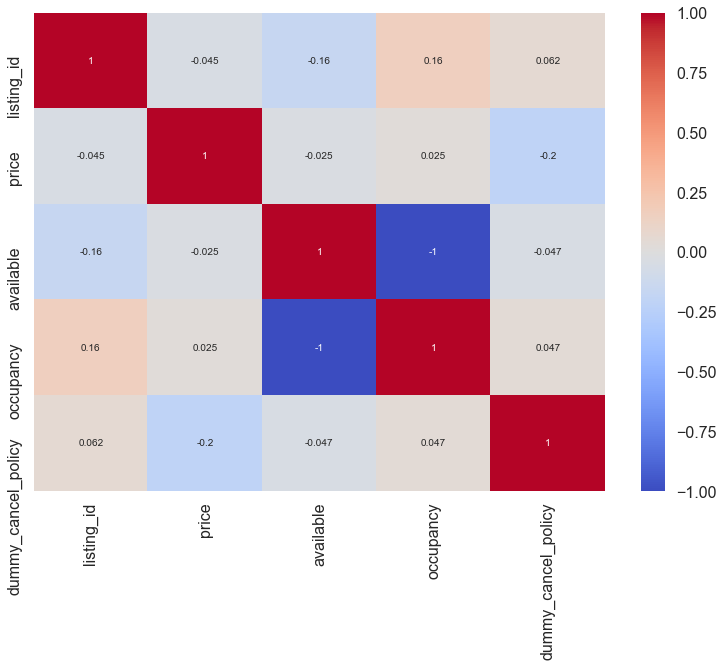

In [89]:
#Carrying out correlation visualization using subsetted data 

correlatonMatrix = merging_df.corr()
sns.heatmap(correlatonMatrix, annot=True, fmt= '.2g',cmap= 'coolwarm' )


According to the correlation matrix, there is no real linear correlation between occupancy and what the cancelation policy is. 



# Conclusion

After carrying out data analysis on Seattle Airbnb data which consisted of 3818 listings for 365 days from 2016 to 2017 to get insights into Airbnb business in Seattle and find answers to some of the questions we had, we were able to derive valuable insights and draw conclusive answers to some questions.

Some of the insights we got were that as occupancy declines during the year, price decreases too. However we were not able to establish a correlation between occupancy and prices. We also were not able to establish a correlation between cancelation policy and bookings. On the other hand we got some of the conclusive answers we got are that the size of a listing is a very important feature in determining the listing price along side reviews and cleaning fee. Meanwhile to conclude on some questions we may need more data, for example; the number of listings in some neighborhoods were so small and insufficient enough to get an acurate trend. We will get more trend insight if we combined data from different years to establish patterns. 

Moving on, we can look into the highly priced listings (listing price outliers) to understand why these listings are priced way higher than normal. Also, we can look into Airbnb data from different cities and compare them with each other.

